In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
# 計算組合績效：期望回報和風險
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / std
    return returns, std, sharpe_ratio

In [3]:
# 最小化風險以找到給定回報的最佳組合
def minimize_volatility(weights, mean_returns, cov_matrix, target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1], weights,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [4]:
# 找到最大夏普比率的組合
def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.02):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    # 使用均等分佈作為初始猜測值
    initial_guess = np.array([1. / num_assets] * num_assets)
    result = minimize(lambda x: -portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[2],
                      initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [5]:
# 計算效率前緣曲線
def calculate_efficient_frontier(mean_returns, cov_matrix, num_points=100):
    results = {'returns': [], 'volatility': []}
    num_assets = len(mean_returns)
    weights = np.array([1 / num_assets] * num_assets)
    target_returns = np.linspace(mean_returns.min() * 0.8, mean_returns.max() * 1.2, num_points)

    for target_return in target_returns:
        optimized_result = minimize_volatility(weights, mean_returns, cov_matrix, target_return)
        if optimized_result.success:
            ret, vol, _ = portfolio_performance(optimized_result.x, mean_returns, cov_matrix)
            results['returns'].append(ret)
            results['volatility'].append(vol)

    return results

In [16]:
# 使用蒙地卡羅模擬生成隨機組合並繪製效率前緣
def monte_carlo_simulation(mean_returns, cov_matrix, num_portfolios=5000, risk_free_rate=0.02):
    np.random.seed(42)
    num_assets = len(mean_returns)
    results = {'returns': [], 'volatility': [], 'sharpe_ratios': [], 'weights': []}

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        results['returns'].append(ret)
        results['volatility'].append(vol)
        results['sharpe_ratios'].append(sharpe)
        results['weights'].append(weights)

    # 找到最大夏普比率的組合
    max_sharpe_idx = np.argmax(results['sharpe_ratios'])
    max_sharpe_ret = results['returns'][max_sharpe_idx]
    max_sharpe_vol = results['volatility'][max_sharpe_idx]

    # 找到最小波動率的組合
    min_vol_idx = np.argmin(results['volatility'])
    min_vol_ret = results['returns'][min_vol_idx]
    min_vol_vol = results['volatility'][min_vol_idx]

    # 計算效率前緣曲線
    efficient_frontier = calculate_efficient_frontier(mean_returns, cov_matrix)

    # 繪製蒙地卡羅模擬的結果和效率前緣
    plt.figure(figsize=(10, 6))
    plt.scatter(results['volatility'], results['returns'], c=results['sharpe_ratios'], cmap='viridis', alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(min_vol_vol, min_vol_ret, marker='*', color='r', s=200, label='Minimum Volatility')
    plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], color='b', linestyle='-', linewidth=2, label='Efficient Frontier', zorder=3)
    plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='+', color='b', s=200, label='Maximum Sharpe Ratio', zorder=4)
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Monte Carlo Simulation with Efficient Frontier for Portfolio')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# 使用滾動視窗計算效率前緣並繪製代表圖形
def rolling_efficient_frontier(stock_symbols, window=120, start_date='2017-01-01', end_date='2023-01-01'):
    # 1. 下載所有股票數據並計算日回報率
    data = pd.DataFrame()
    for symbol in stock_symbols:
        stock_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
        stock_data.name = symbol
        data = pd.concat([data, stock_data], axis=1)

    # 2. 滾動計算效率前緣並繪製一張代表圖形
    rolling_windows = data.rolling(window=window)
    mean_returns_list = []
    cov_matrix_list = []
    for i in range(window, len(data)):
        rolling_data = data.iloc[i - window:i]
        mean_returns = rolling_data.mean()
        cov_matrix = rolling_data.cov()
        mean_returns_list.append(mean_returns)
        cov_matrix_list.append(cov_matrix)

    # 使用最後一個滾動視窗的結果進行蒙地卡羅模擬並繪製效率前緣
    if mean_returns_list and cov_matrix_list:
        monte_carlo_simulation(mean_returns_list[-1], cov_matrix_list[-1])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


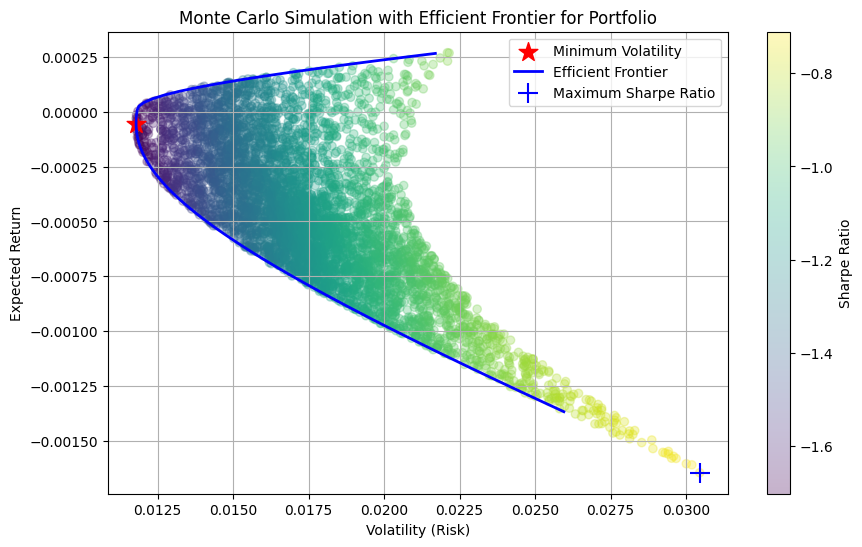

In [17]:
# 計算並繪製效率前緣
rolling_efficient_frontier(['2330.TW', '2317.TW', '2603.TW'])